In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from src.model_specpred import SpectrumPredictor
from src.utils_model import lorentzian, spec_to_Sqt, batch_spec_to_Sqt

from matplotlib.colors import to_rgb, to_rgba

from matplotlib.colors import Normalize
from scipy.interpolate import interp1d
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

torch.set_default_dtype(torch.float64)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

c:\Users\zhant\.conda\envs\sqt\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
import config_matplotlib
import seaborn
palette_crest = seaborn.color_palette(palette='crest')
palette_flare = seaborn.color_palette(palette='flare')

In [3]:
model_spec = SpectrumPredictor.load_from_checkpoint(
    "production_models/version_large_training_set/checkpoints/epoch=8456-step=422850.ckpt")

In [4]:
data = torch.load("data/CrI3/20221110.pt")
X = data['param'][:,:2]
Y = torch.cat((data['omega'], data['inten']), dim=1)

indices_dict = torch.load("data_splitting/indices_42_800-100-100.pt")
train_indices = indices_dict['train']
val_indices = indices_dict['val']
test_indices = indices_dict['test']

X_train = X[train_indices]
Y_train = Y[train_indices]
train_dataset = TensorDataset(X_train, Y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

X_test = X[test_indices]
Y_test = Y[test_indices]

print("print some values for further reference:")
# print("training:\n", X_train[:5])
# print("validation:\n", X_val[:5])
print("testing:\n", X_test[:5])

print some values for further reference:
testing:
 tensor([[-1.5924e+00, -2.1911e-01],
        [-2.9503e+00, -8.5994e-04],
        [-1.6105e+00, -2.4190e-01],
        [-2.3308e+00, -4.2538e-01],
        [-1.8445e+00, -5.6670e-01]])


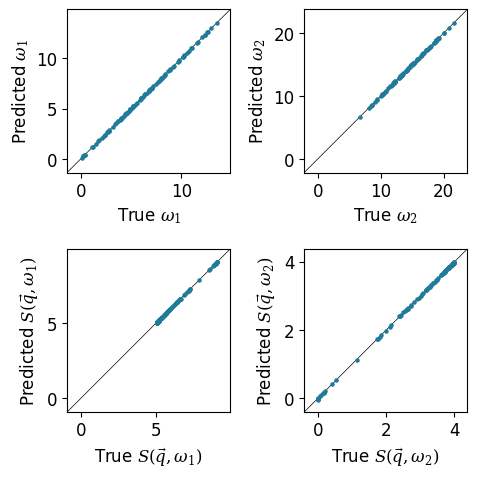

In [5]:
model_spec.to(device)

loss_test = []
Y_test_pred = []
with torch.no_grad():
    for x_test, y_test in zip(X_test, Y_test):
        y_test_pred = model_spec(x_test.to(device)).detach().cpu()
        loss_test.append((y_test_pred - y_test).abs().mean().item())
        Y_test_pred.append(y_test_pred)
Y_test_pred = torch.vstack(Y_test_pred)

labels = [r'$\omega_1$', r'$\omega_2$', r'$S(\vec{q},\omega_{1})$', r'$S(\vec{q},\omega_{2})$']

fig = plt.figure(figsize=(5,5))
gs = plt.GridSpec(2,2)
for i in range(4):
    ax = fig.add_subplot(gs[i])
    ax.plot([-100,100], [-100,100], 'k', linewidth=0.5, zorder=0)
    ax.scatter(Y_test[:,i], Y_test_pred[:,i], s=5, color="#207A9A", zorder=10)
    ax.set_aspect('equal')
    ax.set_xlim([-0.1*Y_test[:,i].max(), 1.1*Y_test[:,i].max()])
    ax.set_ylim([-0.1*Y_test[:,i].max(), 1.1*Y_test[:,i].max()])
    ax.set_xlabel(f"True {labels[i]}", fontsize=12)
    ax.set_ylabel(f"Predicted {labels[i]}", fontsize=12)

fig.tight_layout()
# fig.savefig("figs/paper/network_hist2d.pdf", bbox_inches='tight')

In [6]:
# from laplace.baselaplace import FullLaplace, DiagLaplace
# from laplace.curvature.backpack import BackPackGGN

# from laplace import Laplace, marglik_training

In [7]:
print(model_spec)

SpectrumPredictor(
  (fc_net): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=4, bias=False)
  )
)


In [8]:
gamma = 0.1
# times = np.arange(0,3,0.01)
times = np.linspace(0, 3, 121)
settings = (times, )
n_particles = 501
parameters = (
    np.random.uniform(-3, -1.0, n_particles),
    np.random.uniform(-1.0,-0.0, n_particles),
    np.random.uniform( 0.0, 1.0, n_particles),
    np.random.uniform( 0.0, 10.0, n_particles),
    np.random.uniform( 0.1, 2.0, n_particles)
    )

In [9]:
%load_ext autoreload
%autoreload 2
from src.bayes import BayesianInference, jit_batch_spec_to_Sqt
from src.utils_model import tensor2array, array2tensor
import optbayesexpt as obe
from src.utils_convolution import get_I_conv, interp_nb

In [10]:
from src.utils_general import prepare_sample

def measure_function(sets, pars, cons, func):
    """ Evaluates a trusted model of the experiment's output
    The equivalent of a fit function. The argument structure is
    required by OptBayesExpt.
    Args:
        sets: A tuple of setting values, or a tuple of settings arrays
        pars: A tuple of parameter arrays or a tuple of parameter values
        cons: A tuple of floats
    Returns:  the evaluated function
    """
    # unpack the settings
    # t, = sets
    # unpack model parameters
    t, = sets
    if isinstance(t, (int, float)):
        t = np.array([t,])
    else:
        t = np.atleast_1d(tensor2array(t))
    I_pred = func(t)
    return I_pred

In [11]:
np.where(X_test[:,0]<-2.5)

(array([ 1,  6,  7, 12, 13, 22, 24, 26, 29, 34, 37, 42, 48, 53, 61, 67, 70,
        76, 78, 81, 83, 96, 99], dtype=int64),)

In [12]:
target_idx = 7

pulse_width = 0.1
noise_level = 1
N_steps_bayes = 70
normalize_to_value = 100

In [13]:
from src.CrI3.prepare import prepare_CrI3_sample

# param_true, func_I_conv, func_I_noconv = prepare_CrI3_sample(times, pulse_width=0.1, mode='voigt', E_cutoff=5.0,
#                     amp_increase_factor=1.0, elas_bkg_amp_factor=0.25, elas_bkg_wid=1.5)

c:\Users\zhant\Dropbox\SLAC\research\TopologicalSpinML\topo-spin-Sqt-ML-main\src\utils_convolution.py:19: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  if isinstance(t, (int, float)):


[-2.70187163 -0.74145112  0.1         2.59623076  0.5       ]


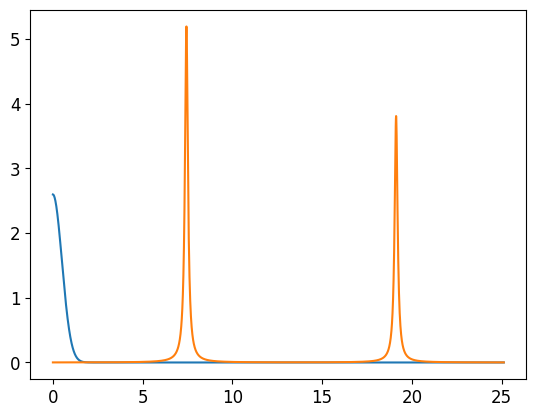

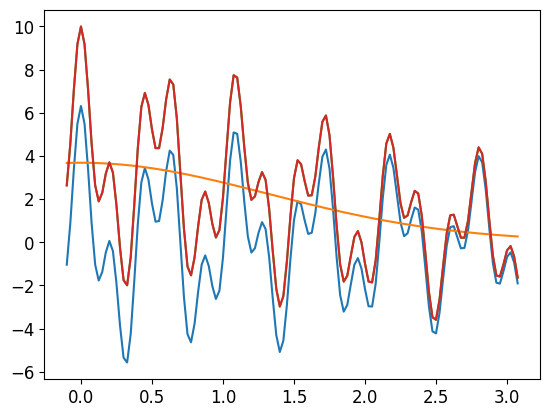

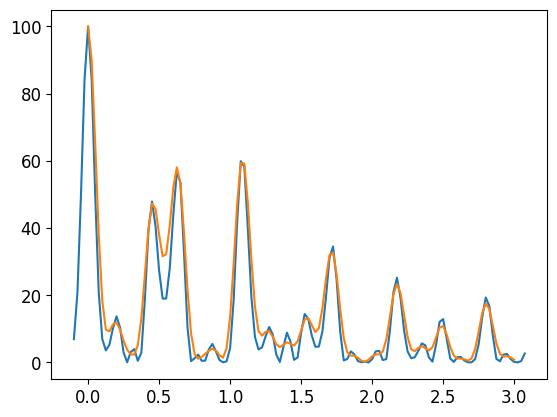

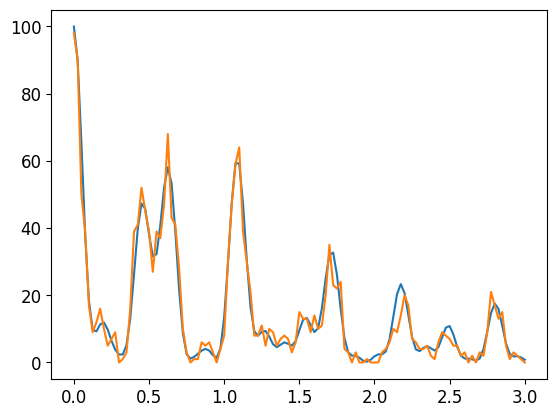

In [14]:
param_true, func_I_conv, func_I_noconv = \
    prepare_sample(X_test[target_idx], Y_test[target_idx], gamma, times, 
                   pulse_width=pulse_width, visualize=True, normalize_to_value=normalize_to_value,
                   elas_amp_factor=0.5, elas_wid=0.5, elas_amp_abs_max=1000.)

# param_true, func_I_conv, func_I_noconv = \
#     prepare_CrI3_sample(times, amp_increase_factor=1.05, pulse_width=pulse_width)
print(param_true)
obe_sim = obe.MeasurementSimulator(
    lambda s, p, c: measure_function(s, p, c, func_I_conv), param_true, (), noise_level=noise_level, noise_mode='poisson')
obe_sim_noisefree = obe.MeasurementSimulator(
    lambda s, p, c: measure_function(s, p, c, func_I_conv), param_true, (), noise_level=0)

plt.figure()
plt.plot(times, obe_sim_noisefree.simdata((times,)))
plt.plot(times, obe_sim.simdata((times,)))
# plt.figure()
# plt.plot(times, np.log(obe_sim.simdata((times,))))
# plt.plot(times, np.log(obe_sim_noisefree.simdata((times,))))

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
from src.bayes import BayesianInference
bayes = BayesianInference(
    model_spec, settings, parameters, noise_level=noise_level,
    pulse_width=pulse_width, reference_setting_value=((0,), normalize_to_value),
    cost_repulse_height=10.0, cost_repulse_width=0.25,
    parameter_mins=(-3,-1,0,0,0.1), parameter_maxs=(-1,0,1,15,2), 
    selection_method='unique_optimal', utility_method='variance_full',
    model_uncertainty=False, device=device)
# bayes.obe_model.set_selection_method('unique_optimal')
# bayes.obe_model.set_selection_method('sequential')

c:\Users\zhant\Dropbox\SLAC\research\TopologicalSpinML\topo-spin-Sqt-ML-main\src\bayes.py:225: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.meV_to_2piTHz).to(y).clone().detach(),
c:\Users\zhant\Dropbox\SLAC\research\TopologicalSpinML\topo-spin-Sqt-ML-main\src\bayes.py:229: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.meV_to_2piTHz).to(y).clone().detach(),


In [17]:
# bayes.obe_model.set_selection_method('sequential')
particles_hist, p_weights_hist, errors, likyhd_hist = bayes.run_N_steps_OptBayesExpt_w_GD(
    40, obe_sim, N_GD=100, lr=0.01, ret_particles=True, verbose=True,
    gd_seperation=14, error_criterion=10)
# particles_hist, p_weights_hist = bayes.run_N_steps_OptBayesExpt(
#     100, obe_sim, ret_particles=True, verbose=True)
print(bayes.obe_model.mean(), bayes.obe_model.std())

using the unique_optimal setting


Running OptBayesExpt:  35%|███▌      | 14/40 [00:06<00:04,  6.05it/s]

running GD at step 14, current error 30.959158556599863


c:\Users\zhant\Dropbox\SLAC\research\TopologicalSpinML\topo-spin-Sqt-ML-main\src\utils_gd.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pulse_width = torch.tensor(pulse_width).to(y).clone().detach()
Running OptBayesExpt:  70%|███████   | 28/40 [00:12<00:02,  5.80it/s]

running GD at step 28, current error 36.547059887420545


Running OptBayesExpt: 100%|██████████| 40/40 [00:14<00:00,  2.69it/s]

[-2.67384653 -0.73019037  0.23097012  2.53766171  0.58407586] [0.00567831 0.00192598 0.02161521 0.19918189 0.03004934]


In [18]:
param_mean = np.asarray(bayes.param_mean)
param_std = np.asarray(bayes.param_std)
utility = np.asarray(bayes.utility_list)

idx_plot = -1
# utility_plot = bayes.utility_list[idx_plot]
# utility_plot = 20 * utility_plot / utility_plot.max()

measured_settings, measured_observables = bayes.get_all_measurements()
_, measurements_noisefree = bayes.measure_all_settings(obe_sim_noisefree)
_, measurements_predicted = bayes.predict_all_settings(param_mean[idx_plot-1])
# _, measurements_predicted = bayes.predict_all_settings(param_true)
measurements_predicted *= normalize_to_value / measurements_predicted[0]

assert measured_settings.shape[0] == np.unique(measured_settings).shape[0]

In [19]:
all_model_predictions = np.vstack([bayes.predict_all_settings(param_mean[i])[1] for i in range(param_mean.shape[0])])

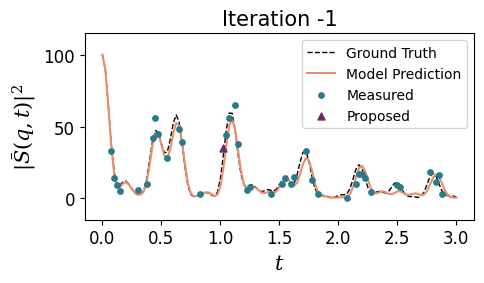

In [22]:
maxiter = len(param_mean)

colors = [palette_crest[0], palette_crest[-3], palette_flare[0]]

label_lst = ["$J$", "$D$", "$\gamma$"]
fig, ax = plt.subplots(1,1,figsize=(5,3))

ax.plot(times.squeeze(), measurements_noisefree, 'k--', label="Ground Truth", zorder=5, linewidth=1)
# # ax[1].plot(time_val, model_function((time_val,), obe_model.mean(), ()), 'r--', label="Ground Truth")
ax.plot(times.squeeze(), measurements_predicted, color=palette_flare[0], label="Model Prediction", zorder=5)
# ax.fill_between(times.squeeze(), measurements_predicted-utility_plot, measurements_predicted+utility_plot, color=palette_flare[0], zorder=1, alpha=0.25)
ax.scatter(measured_settings.squeeze()[:idx_plot], measured_observables.squeeze()[:idx_plot], label="Measured", s=15, color=palette_crest[-3], zorder=10)
ax.scatter(measured_settings.squeeze()[idx_plot], measured_observables.squeeze()[idx_plot], label="Proposed", s=25, color=palette_flare[-1], zorder=20, marker='^')
ax.legend(fontsize=10)
ax.set_xlabel('$t$', fontsize=15)
ax.set_ylim([-15, measurements_noisefree.max()+15])
ax.set_ylabel(r'$\left|\bar{S}(q,t)\right|^{2}$', fontsize=15)
ax.set_title(f"Iteration {idx_plot}", fontsize=15)

fig.tight_layout()
# fig.savefig(f'figs/paper/exp_steering_sqt_sample{idx}_iter{idx_plot}.pdf')

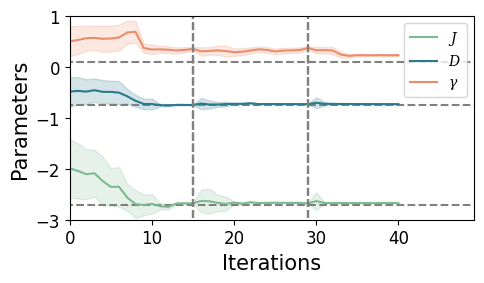

In [23]:
maxiter = len(param_mean)

colors = [palette_crest[0], palette_crest[-3], palette_flare[0], palette_flare[-3], palette_flare[-1]]

label_lst = ["$J$", "$D$", "$\gamma$", "$a$", "$\sigma$"]
fig, ax = plt.subplots(1,1,figsize=(5,3))
for i in range(5):
    if i <= 2:
        ax.fill_between(np.arange(maxiter), param_mean[:,i]-param_std[:,i], param_mean[:,i]+param_std[:,i], color=colors[i], alpha=0.2)
        ax.hlines(param_true[i], -100, 100*maxiter, linestyles='--', color='gray')
        ax.plot(np.arange(maxiter), param_mean[:,i], color=colors[i], label=label_lst[i])
    ax.vlines(15, -100, 100, linestyles='--', color='gray')
    ax.vlines(29, -100, 100, linestyles='--', color='gray')
ax.set_xlim([-0.*maxiter, 1.2*maxiter])
ax.set_ylim([-3, 1])
ax.legend(loc='best', fontsize=10)
ax.set_xlabel("Iterations", fontsize=15)
ax.set_ylabel("Parameters", fontsize=15)

fig.tight_layout()
# fig.savefig(f'figs/paper/exp_steering_paramhist_sample{idx}.pdf')

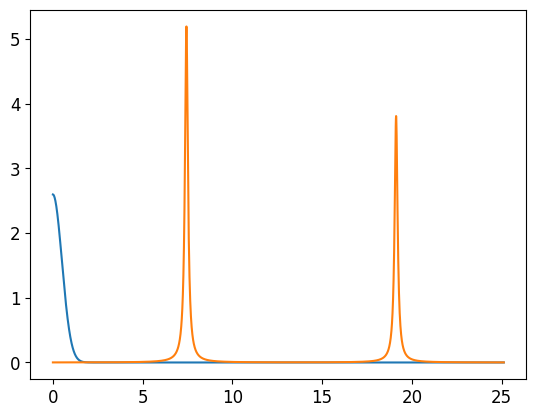

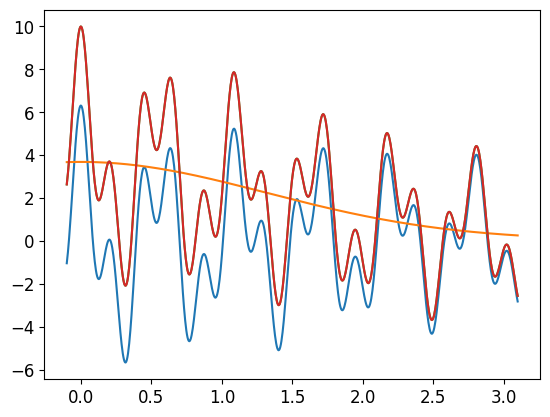

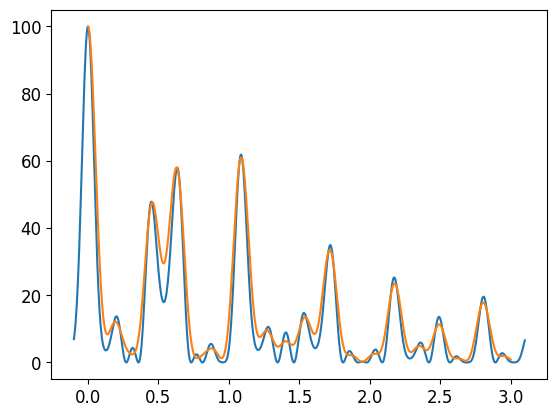

In [36]:
from sklearn.neighbors import KernelDensity


times_finer = np.linspace(times.min(), times.max(), 6*times.shape[0])
_, func_I_conv_finertime, _ = \
    prepare_sample(X_test[target_idx], Y_test[target_idx], gamma, times_finer, 
                   pulse_width=pulse_width, visualize=True, normalize_to_value=normalize_to_value,
                   elas_amp_factor=0.5, elas_wid=0.5, elas_amp_abs_max=1000.)
signals_finer = func_I_conv_finertime(times_finer)
signals = func_I_conv(times)

In [26]:
J_grid, D_grid = np.meshgrid(np.linspace(-3,-1,201),np.linspace(-1,0,101))
X_grid = np.concatenate([J_grid[...,None], D_grid[...,None]], axis=-1).reshape(-1,2)

n_iter_before = 7
X_before = particles_hist[n_iter_before,:2]
X_weight_before = p_weights_hist[n_iter_before]
X_true = param_true.copy()

kde_before = KernelDensity(kernel="exponential", bandwidth="scott").fit(X_before.T, sample_weight=X_weight_before)
log_dens_before = kde_before.score_samples(X_grid).reshape(J_grid.shape)

likyhd = likyhd_hist[n_iter_before]
kde_likyhd = KernelDensity(kernel="exponential", bandwidth="scott").fit(X_before.T, sample_weight=likyhd)

log_dens_likyhd = kde_likyhd.score_samples(X_grid).reshape(J_grid.shape)

n_iter_after = n_iter_before + 1
X_after = particles_hist[n_iter_after,:2]
X_weight_after = p_weights_hist[n_iter_after]
kde_after = KernelDensity(kernel="exponential", bandwidth="scott").fit(X_after.T, sample_weight=X_weight_after)
# log_dens = kde.score_samples(X_plot)

log_dens_after = kde_after.score_samples(X_grid).reshape(J_grid.shape)

# log_dens_likyhd 


Text(0, 0.5, 'Parameters')

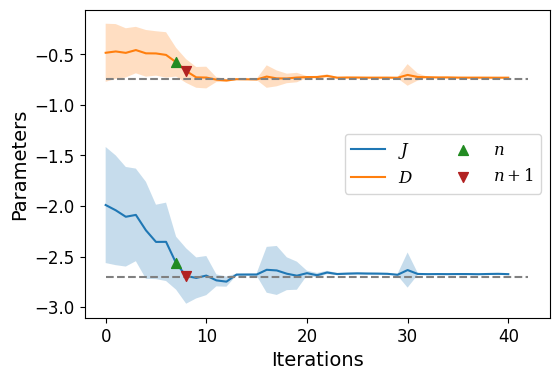

In [27]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(param_mean[:,0], label='$J$')
ax.plot(param_mean[:,1], label='$D$')
ax.fill_between(np.arange(41), 
                param_mean[:,0] - param_std[:,0],
                param_mean[:,0] + param_std[:,0], alpha=0.25)
ax.fill_between(np.arange(41), 
                param_mean[:,1] - param_std[:,1],
                param_mean[:,1] + param_std[:,1], alpha=0.25)
ax.scatter([n_iter_before, n_iter_before], 
           [param_mean[n_iter_before,0], param_mean[n_iter_before,1]], 
           marker='^', s=50, zorder=3, color='forestgreen', label='$n$')
ax.scatter([n_iter_after, n_iter_after], 
           [param_mean[n_iter_after,0], param_mean[n_iter_after,1]], 
           marker='v', s=50, zorder=3, color='firebrick', label='$n+1$')
ax.hlines(param_true[0], 0, 42, linestyles='--', colors='gray')
ax.hlines(param_true[1], 0, 42, linestyles='--', colors='gray')
ax.legend(ncols=2)
ax.set_xlabel('Iterations', fontsize=14)
ax.set_ylabel('Parameters', fontsize=14)
# fig.savefig('figures/bayesian_illustration/parameters.pdf', bbox_inches='tight')

Text(0.5, 1.0, '$P(s_{n+1}|x,t_{n+1})$')

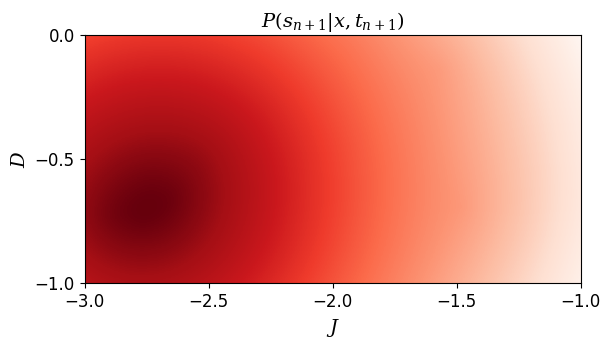

In [28]:
import matplotlib.ticker as plticker

xloc = plticker.MultipleLocator(base=0.5) # this locator puts ticks at regular intervals
yloc = plticker.MultipleLocator(base=0.5) # this locator puts ticks at regular intervals


fig, ax = plt.subplots(1,1)
# ax.imshow(np.exp(log_dens_likyhd), extent=[-3, -1, -1, 0], origin='lower', cmap='Reds')
ax.imshow(log_dens_likyhd, extent=[-3, -1, -1, 0], origin='lower', cmap='Reds')
# ax.scatter(X[0], X[1])
# ax.scatter(X_true[0], X_true[1], marker='*', color='firebrick')
ax.set_aspect('equal')
ax.set_xlabel('$J$', fontsize=14)
ax.xaxis.set_major_locator(xloc)
ax.set_ylabel('$D$', fontsize=14)
ax.yaxis.set_major_locator(yloc)
ax.set_title(r'$P(s_{n+1}|x,t_{n+1})$', fontsize=14)
# fig.savefig('figures/bayesian_illustration/likyhd.pdf', bbox_inches='tight')

Text(0.5, 1.0, '$P_{n+1}(x)$')

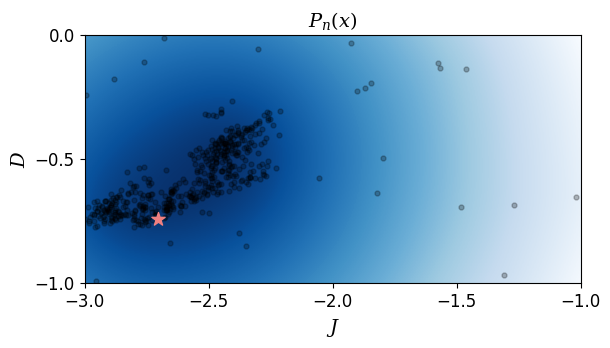

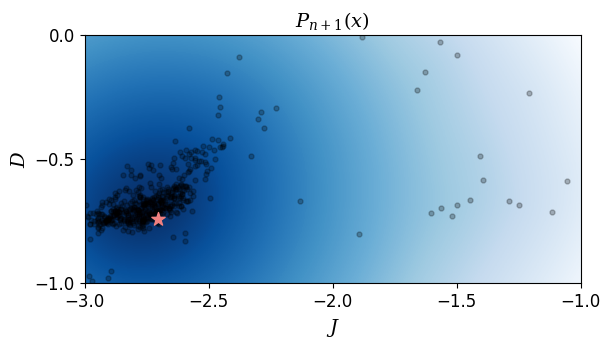

In [29]:
fig, ax = plt.subplots(1,1)
# ax.imshow(np.exp(log_dens_before), extent=[-3, -1, -1, 0], origin='lower', cmap='Blues')
ax.imshow(log_dens_before, extent=[-3, -1, -1, 0], origin='lower', cmap='Blues')
ax.scatter(particles_hist[n_iter_before,0], particles_hist[n_iter_before,1], marker='.', color='k', s=50, alpha=0.25, edgecolor=None)
# ax.scatter(X[0], X[1])
ax.scatter(X_true[0], X_true[1], marker='*', color='lightcoral', s=100)
ax.set_aspect('equal')
ax.set_xlabel('$J$', fontsize=14)
ax.xaxis.set_major_locator(xloc)
ax.set_ylabel('$D$', fontsize=14)
ax.yaxis.set_major_locator(yloc)
ax.set_title(r'$P_{n}(x)$', fontsize=14)
# fig.savefig('figures/bayesian_illustration/prior.pdf', bbox_inches='tight')

fig, ax = plt.subplots(1,1)
# ax.imshow(np.exp(log_dens_after), extent=[-3, -1, -1, 0], origin='lower', cmap='Blues')
ax.imshow(log_dens_after, extent=[-3, -1, -1, 0], origin='lower', cmap='Blues')
ax.scatter(particles_hist[n_iter_after,0], particles_hist[n_iter_after,1], marker='.', color='k', s=50, alpha=0.25, edgecolor=None)
ax.scatter(X_true[0], X_true[1], marker='*', color='lightcoral', s=100)
ax.set_aspect('equal')
ax.set_xlabel('$J$', fontsize=14)
ax.xaxis.set_major_locator(xloc)
ax.set_ylabel('$D$', fontsize=14)
ax.yaxis.set_major_locator(yloc)
ax.set_title(r'$P_{n+1}(x)$', fontsize=14)
# fig.savefig('figures/bayesian_illustration/posterior.pdf', bbox_inches='tight')

Text(0, 0.5, '$s(t)$')

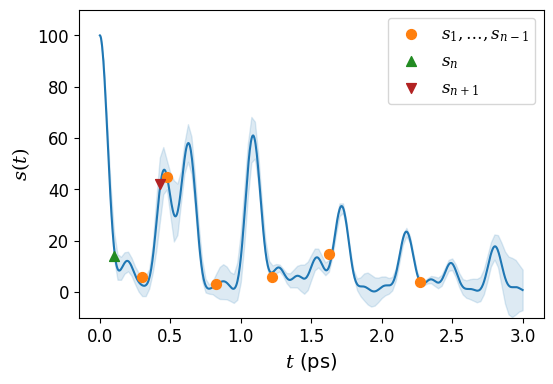

In [37]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(times_finer, signals_finer, zorder=0, color='C0')
ax.scatter(measured_settings[:n_iter_before-1], 
           measured_observables[:n_iter_before-1], 
           zorder=2, color='C1', s=50, label='$s_{1}, \ldots, s_{n-1}$')
ax.fill_between(times, 
                signals-utility[n_iter_before], 
                signals+utility[n_iter_before], 
                alpha=0.15, zorder=1, color='C0')
ax.scatter(measured_settings[n_iter_before-1], 
           measured_observables[n_iter_before-1], 
           marker='^', zorder=2, color='forestgreen', s=50, label='$s_{n}$')
ax.scatter(measured_settings[n_iter_before], 
           measured_observables[n_iter_before], 
           marker='v', zorder=3, color='firebrick', s=50, label='$s_{n+1}$')
# ax.vlines(times[np.argmax(data_dict[i_sample]['utility'][n_iter_before])], -100, 100, linestyles='--', color='gray')
ax.set_ylim([-10, 110])
ax.legend()
ax.set_xlabel('$t$ (ps)', fontsize=14)
ax.set_ylabel('$s(t)$', fontsize=14)
# fig.savefig('figures/bayesian_illustration/st.pdf', bbox_inches='tight')

In [38]:
torch.save(
    {
        'times': times,
        'signals': signals,
        'times_finer': times_finer,
        'signals_finer': signals_finer,
        'signals_predicted': all_model_predictions,
        'param_true': param_true,
        'utility': utility,
        'param_mean': param_mean,
        'param_std': param_std,
        'measured_settings': measured_settings,
        'measured_observables': measured_observables,
        'particles_hist': particles_hist,
        'p_weights_hist': p_weights_hist,
        'likyhd_hist': likyhd_hist,
    }, 'figures/bayesian_illustration/bayes_demo_data.pt'
)